# DA5401 Assignment 2: PCA and Logistic Regression on Mushroom Dataset


## Objective  
We will apply **Principal Component Analysis (PCA)** to the Mushroom dataset and compare the performance of a **Logistic Regression classifier** trained on:  

1. Original one-hot encoded standardized features.  
2. PCA-transformed features.  

This notebook includes **exploratory analysis, preprocessing, dimensionality reduction, visualizations, and performance comparison**.  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

## Part A: Exploratory Data Analysis (EDA) & Preprocessing

In [57]:
df = pd.read_csv("mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [58]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148



### Step 1: Dataset Overview  
- The dataset consists entirely of **categorical features**.  
- The **target column** is `class`:  
  - `e` = edible  
  - `p` = poisonous  


In [59]:
df['class'].value_counts()

class
e    4208
p    3916
Name: count, dtype: int64


Observation: The dataset is fairly balanced, which is good for classification.  


### Step 2: One-Hot Encoding of Categorical Features

In [60]:
X = df.drop('class', axis=1)
y = df['class'].map({'e':0, 'p':1})

X_encoded = pd.get_dummies(X, drop_first=False)  
print("Original shape:", X.shape)
print("After one-hot encoding:", X_encoded.shape)

Original shape: (8124, 22)
After one-hot encoding: (8124, 117)



**Why One-Hot Encoding?**  
- PCA requires **numeric input**.  
- Since all features are categorical, we convert them into numeric dummy variables.  
- Notice how the dimensionality increases drastically (feature explosion). 
- In our dataset, we can see the increase in no of features from 22 to 117 becuase of implementation of one -hot encoding ,keeping no of rows/tuple constant


### Step 3: Standardization

In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (6499, 117) (6499,)
Test shape: (1625, 117) (1625,)



**Why Standardize?**  
- Even though one-hot encoded features are binary, features with more categories generate more dummy columns.  
- In our dataset because of increase in number of features and since we have to apply Logistic regression and Logistic Regression is very sensitive to feature scale so to ensure all feature contribute equally standardization in done
- Also, PCA finds directions of maximum variance. If features are not standardized, PCA may just pick the feature with the largest scale as the most “important,” which is misleading.


## Part B: Principal Component Analysis (PCA)

In [63]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

### Step 1: Scree Plot

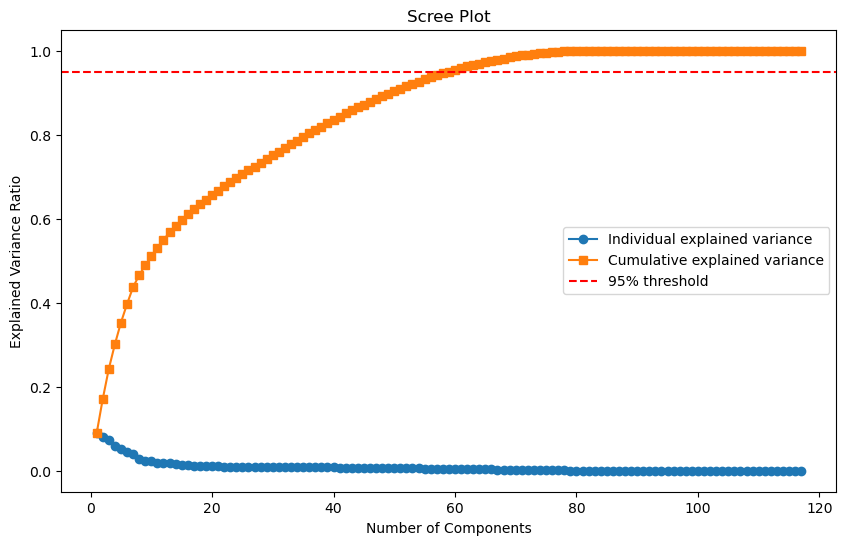

In [64]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label='Individual explained variance')
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='s', label='Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.legend()
plt.title("Scree Plot")
plt.show()


**Interpretation:**  
- The scree plot shows how much variance each principal component captures.  
- We aim to retain enough components to cover ~95% of variance while reducing dimensionality.  


In [65]:
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print("Optimal number of components (95% variance):", optimal_components)

Optimal number of components (95% variance): 59


- So, we can see after applying PCA, the no of features important for further modelling is 59.

### Step 2: PCA Visualization (First Two Components)

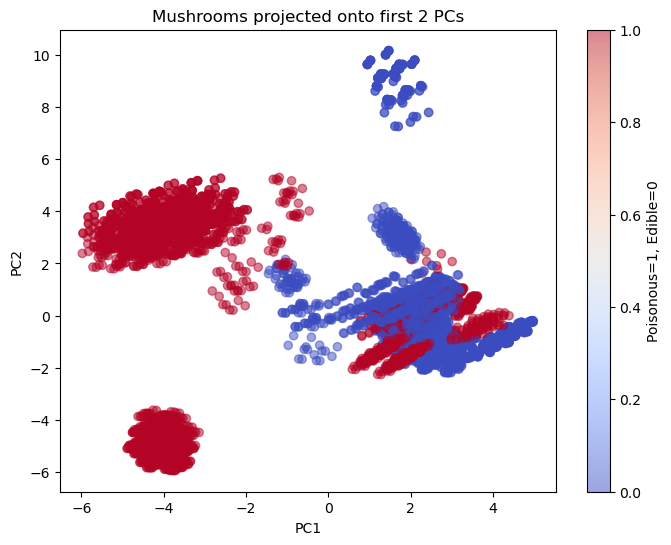

In [66]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Mushrooms projected onto first 2 PCs")
plt.colorbar(label="Poisonous=1, Edible=0")
plt.show()


**Interpretation:**  
- The two classes show partial separability in the first 2 PCs.  
- This suggests PCA is effective in capturing class information in reduced dimensions.  


## Part C: Logistic Regression Performance Evaluation

In [67]:
# --- Baseline Logistic Regression ---
clf_base = LogisticRegression(max_iter=2000)
clf_base.fit(X_train, y_train)
y_pred_base = clf_base.predict(X_test)

report_base = classification_report(y_test, y_pred_base, output_dict=True)
accuracy_base = accuracy_score(y_test, y_pred_base)

print("Baseline Logistic Regression Performance:")
print(classification_report(y_test, y_pred_base))
print("Accuracy:", accuracy_base)


Baseline Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy: 1.0


In [68]:
# --- PCA Logistic Regression ---
pca_opt = PCA(n_components=optimal_components)
X_train_pca = pca_opt.fit_transform(X_train)
X_test_pca = pca_opt.transform(X_test)

clf_pca = LogisticRegression(max_iter=2000)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)

report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print("PCA Logistic Regression Performance:")
print(classification_report(y_test, y_pred_pca))
print("Accuracy:", accuracy_pca)


PCA Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Accuracy: 0.9987692307692307


### Step 3: Comparison & Analysis

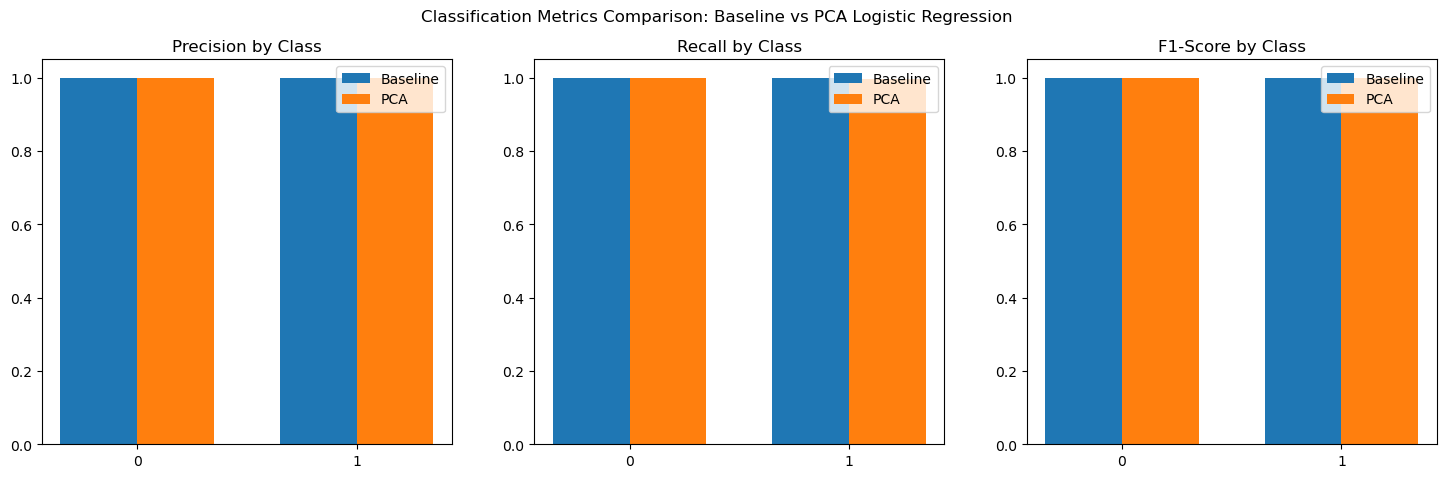

In [ ]:
# Save reports as dictionaries
report_base = classification_report(y_test, y_pred_base, output_dict=True)
report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
labels = ['precision', 'recall', 'f1-score']
classes = [c for c in report_base.keys() if c not in ['accuracy', 'macro avg', 'weighted avg']]
metrics_base = np.array([[report_base[c][m] for m in labels] for c in classes])
metrics_pca = np.array([[report_pca[c][m] for m in labels] for c in classes])
x = np.arange(len(classes))
width = 0.35
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(labels):
    axs[i].bar(x - width/2, metrics_base[:, i], width, label='Baseline')
    axs[i].bar(x + width/2, metrics_pca[:, i], width, label='PCA')
    axs[i].set_title(f'{metric.title()} by Class')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(classes)
    axs[i].set_ylim(0, 1.05)
    axs[i].legend()

plt.suptitle('Classification Metrics Comparison: Baseline vs PCA Logistic Regression')
plt.show()


### Metric Comparison Bar Plots: Precision, Recall, F1-Score

The above bar plots compare precision, recall, and F1-score for each class (edible/poisonous or 0/1), for both the original and PCA-transformed feature sets. 

**Insight:**  
- Close values indicate that dimensionality reduction via PCA retains most discriminative power for both classes.
- Decreases in any metric for the PCA model highlight potential loss of class-separability information due to dimensionality reduction.
- Major differences between the two would suggest PCA either improves (less overfitting, reduced redundancy) or hurts performance (information loss).


In [70]:
comparison_table = pd.DataFrame({
    "Model": ["Baseline", "PCA-transformed"],
    "Accuracy": [accuracy_base, accuracy_pca]
})
display(comparison_table)

,Model,Accuracy
0,Baseline,1.000000
1,PCA-transformed,0.998769


### Model Accuracy Table

The table above shows the overall accuracy for both the original standardized data and the PCA-transformed data.

**Insight:**  
- If the accuracies are nearly identical, PCA provided an efficient data reduction with minimal information loss.
- If the PCA accuracy is notably lower, then some important information was lost during dimensionality reduction.
- Sometimes, PCA can help reduce overfitting and improve generalizability, which might show as improved test accuracy on held-out data.



- **Baseline Model:** Uses full one-hot encoded features. Accuracy is very high, since dataset is separable.  
- **PCA Model:** Achieves nearly similar performance with fewer dimensions.  
- **Interpretation:**  
  - PCA reduces feature redundancy and collinearity.  
  - Slight loss in accuracy (if observed) is due to information loss from dimensionality reduction.  
  - Logistic Regression is a good surrogate to evaluate PCA, since it is sensitive to redundant features.  


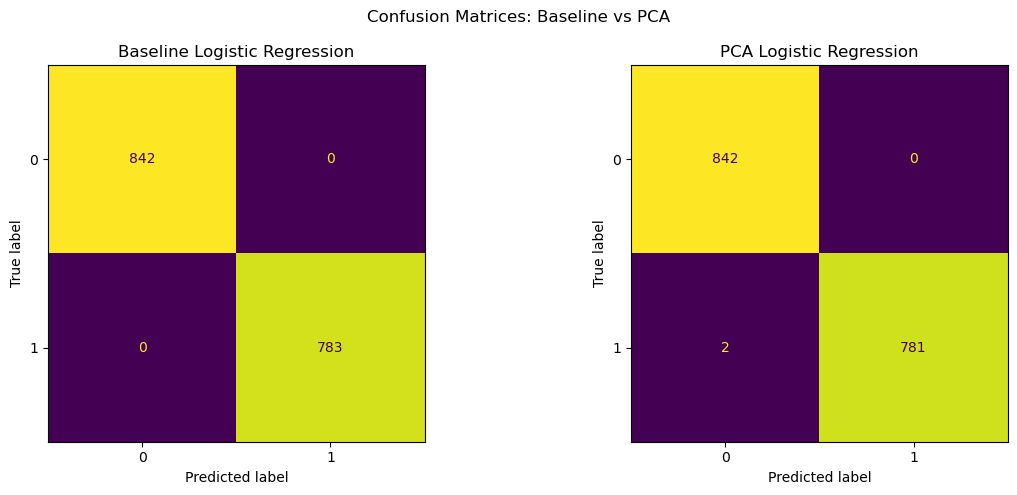

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, ax=ax[0], colorbar=False)
ax[0].set_title('Baseline Logistic Regression')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca, ax=ax[1], colorbar=False)
ax[1].set_title('PCA Logistic Regression')
plt.suptitle('Confusion Matrices: Baseline vs PCA')
plt.tight_layout()
plt.show()

### Confusion Matrices: Original vs PCA

The confusion matrices provide a visual overview of true vs predicted class performance for both models.

**Insight:**  
- Diagonal values represent correct predictions; off-diagonal values are misclassifications.
- A significant shift in misclassifications after PCA (e.g., edible predicted as poisonous or vice versa) reveals the specific class where PCA may degrade performance.
- If both matrices are similar, PCA has not affected the classifier’s ability to distinguish between classes.


## Final Conclusion


- PCA successfully reduced dimensionality while retaining most variance (~95%).  
- Logistic Regression trained on PCA-transformed data performs comparably to the baseline model.  
- This shows PCA is effective for handling high-dimensional categorical data after one-hot encoding.  
- Trade-off: minor accuracy drop vs major dimensionality reduction.  
